In [1]:
import numpy as np
import tensorflow as tf
import pylab
%matplotlib inline

In [85]:
X_data = np.loadtxt('./coordinates1.csv', delimiter='$').astype('float64')[:400,:]
#X_data /= np.max(X_data)    # Divide by the maximum WHY??

Y_data = np.loadtxt('./data_genotypes1.csv', delimiter='$').astype('float64')[:400,:]

[[ 0.          0.        ]
 [ 0.          0.03333333]
 [ 0.          0.06666667]
 [ 0.          0.1       ]
 [ 0.          0.13333333]
 [ 0.          0.16666667]
 [ 0.          0.2       ]
 [ 0.          0.23333333]
 [ 0.          0.26666667]
 [ 0.          0.3       ]
 [ 0.          0.33333333]
 [ 0.          0.36666667]
 [ 0.          0.4       ]
 [ 0.          0.43333333]
 [ 0.          0.46666667]
 [ 0.          0.5       ]
 [ 0.          0.53333333]
 [ 0.          0.56666667]
 [ 0.          0.6       ]
 [ 0.          0.63333333]
 [ 0.          0.66666667]
 [ 0.          0.7       ]
 [ 0.          0.73333333]
 [ 0.          0.76666667]
 [ 0.          0.8       ]
 [ 0.          0.83333333]
 [ 0.          0.86666667]
 [ 0.          0.9       ]
 [ 0.          0.93333333]
 [ 0.          0.96666667]
 [ 0.          1.        ]
 [ 0.03333333  0.        ]
 [ 0.03333333  0.03333333]
 [ 0.03333333  0.06666667]
 [ 0.03333333  0.1       ]
 [ 0.03333333  0.13333333]
 [ 0.03333333  0.16666667]
 

In [19]:
assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
print("Dim. of X-data: %i x %i" % (N,k))
M1 = Y_data.shape[0]
M = Y_data.shape[1]
Y_data[Y_data < 0.5] = -1.0
print("Dim. of Y-data: %i x %i" % (M1,M))

Dim. of X-data: 400 x 2
Dim. of Y-data: 400 x 100


In [20]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value=X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value=Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value=np.random.normal(0.0, 0.1, (N, M)).astype('float64'),
                    trainable=True)

    l = tf.placeholder(shape=[], dtype=tf.float64)
    a = tf.placeholder(shape=[], dtype=tf.float64)
    
    eye=tf.Variable(tf.convert_to_tensor(np.eye(N), dtype=tf.float64))

    K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l), reduction_indices=[2])) + \
        0.0001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l), reduction_indices=[2])) + \
       # 0.0001 * eye                

    p = tf.nn.sigmoid(F)            # Calculate probabilities(assuming sigmoid link function)
    Kinv_F = tf.matrix_solve(K, F)  # Calculate K^(-1)*F
    
    data_fit = -tf.reduce_sum(tf.log(1 + tf.exp(-Y * F)), reduction_indices=[0]) # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calcualte 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    g =  (0.5 * (Y + 1) - p) - Kinv_F # Calculate Matrix for Gradients Check
    
    W = p * (1 - p)        # Calculate first part of Hessia. It is diagonal (but here diagonal in every column)
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEADACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    det = tf.reduce_sum(tf.log(tf.matrix_diag_part(tf.cholesky(tf.transpose(B, [2, 0, 1])))))   # Factor of 2??
    
    margL = logL - det

In [21]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.01

In [22]:
a_list = 0.01 * 2 ** np.arange(10)
l_list = 0.001 * 2 ** np.arange(10)

res = []

with tf.Session(config=config) as sess:
    i=0
    for aa in a_list:
        for ll in l_list:
            print("Doing run: %i" % i)
            i+=1
    
            sess.run(tf.global_variables_initializer())

            prev = None
            for i in range(20):
                r = sess.run([opt_op, update, logL, margL], {a: aa, l:ll})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            
            res.append(r[-1])

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.glo

[ 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.28  2.56  5.12]


<matplotlib.colorbar.Colorbar instance at 0x4cf5ab48>

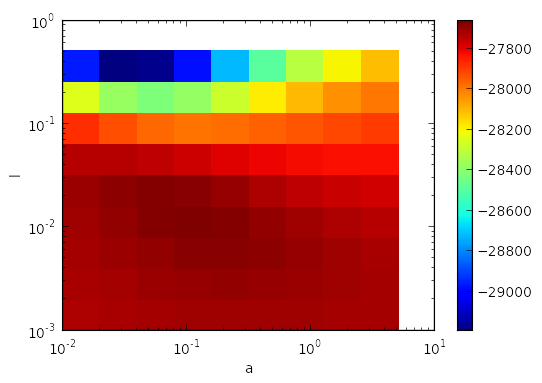

In [83]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(a_list, l_list, surface)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('a')
pylab.ylabel('l')
pylab.colorbar()

In [24]:
np.max(surface) / (N * np.log(2) * M)

-0.99766022474946681

In [75]:
with tf.Session(config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())# Update by Harald
    
    for i in range(3):
        sess.run(opt_op, {a: 0.1, l:0.01})
    r = sess.run(F, {a: 0.1, l: 0.01})
    print(r)

[[-0.24373032 -0.05454187 -0.22432996 ..., -0.17360044 -0.0401117
   0.01674345]
 [-0.25002285 -0.05693831 -0.28218724 ..., -0.17970323 -0.05569959
   0.01042884]
 [-0.22653788 -0.03112334 -0.31755001 ..., -0.17540098 -0.06712458
   0.00251177]
 ..., 
 [-0.21898543  0.00589088  0.08102625 ...,  0.19990443  0.19060701
   0.18047773]
 [-0.16725409  0.04321932  0.11513745 ...,  0.19796825  0.13855245
   0.11831898]
 [-0.08703584  0.07263934  0.13431715 ...,  0.15529049  0.09260848
   0.06890237]]


In [103]:
x, y, z = X_data[:, 0], X_data[:, 1], r[:, 1]
x=np.linspace(0, 1, 20)
print(len(x))

20


<matplotlib.colorbar.Colorbar instance at 0x80326c8>

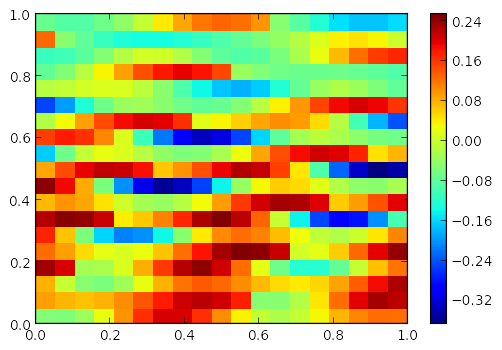

In [104]:
pylab.pcolormesh(x, x, z.reshape(20, 20))
pylab.colorbar()

In [39]:
x.shape

(400,)

In [40]:
y.shape

(400,)

In [41]:
z.shape

(400,)

In [55]:
961 ** 0.5

31.0

In [62]:
with tf.Session() as sess:
    r = sess.run(tf.diag(tf.ones(5)))

In [63]:
r

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]], dtype=float32)

In [64]:
tf.__version__

'0.12.0-rc0'